# Time Series Linear Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('..')

In [3]:
import statslib as stb

import statsmodels.api as sm

import pandas as pd
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt

figsize = (8*1.6, 8)

# Data Set

In [6]:
stb.datasets.uschange.df.index

DatetimeIndex(['1970-03-31', '1970-06-30', '1970-09-30', '1970-12-31',
               '1971-03-31', '1971-06-30', '1971-09-30', '1971-12-31',
               '1972-03-31', '1972-06-30',
               ...
               '2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31',
               '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31',
               '2016-06-30', '2016-09-30'],
              dtype='datetime64[ns]', name='date', length=187, freq='Q-DEC')

In [16]:
stb.datasets.oil.df.head()

,spirit,gravity,pressure,distil,endpoint
0,6.9,38.4,6.1,220,235
1,14.4,40.3,4.8,231,307
2,7.4,40.0,6.1,217,212
3,8.5,31.8,0.2,316,365
4,8.0,40.8,3.5,210,218


In [17]:
stb.datasets.oil.desc

[('spirit', 'percentage yield of petroleum spirit'),
 ('gravity', 'specific gravity of the crude'),
 ('pressure', 'crude oil vapour pressure, measured in pounds per square inch'),
 ('distil', 'the ASTM 10% distillation point, in ◦F'),
 ('endpoint', 'the petroleum fraction end point, in ◦F')]

In [18]:
y = stb.datasets.oil.df.spirit

In [19]:
X = stb.datasets.oil.df.drop('spirit', axis=1)

# Design Matrix

In [20]:
DM = stb.DesignMatrix(y, X)

C:\Users\ashubert\Anaconda3\envs\statslib_envs\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


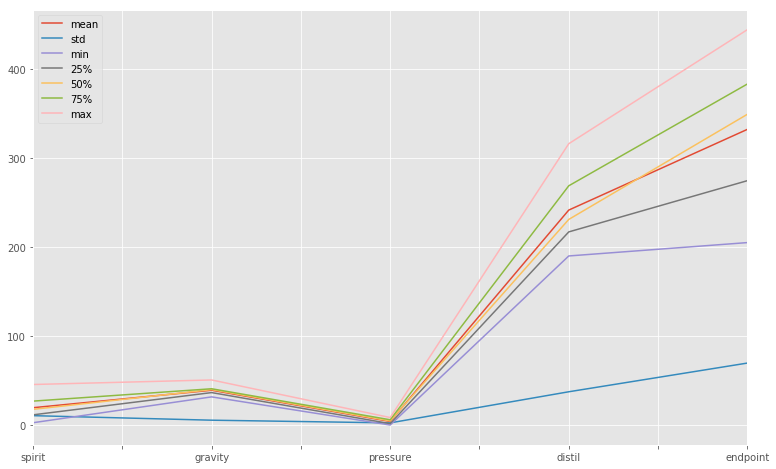

In [21]:
desc = DM.describe()

In [22]:
DM.names

{'v': 'spirit',
 'g1': 'gravity',
 'g2': 'pressure',
 'g3': 'distil',
 'g4': 'endpoint',
 'const': 'const'}

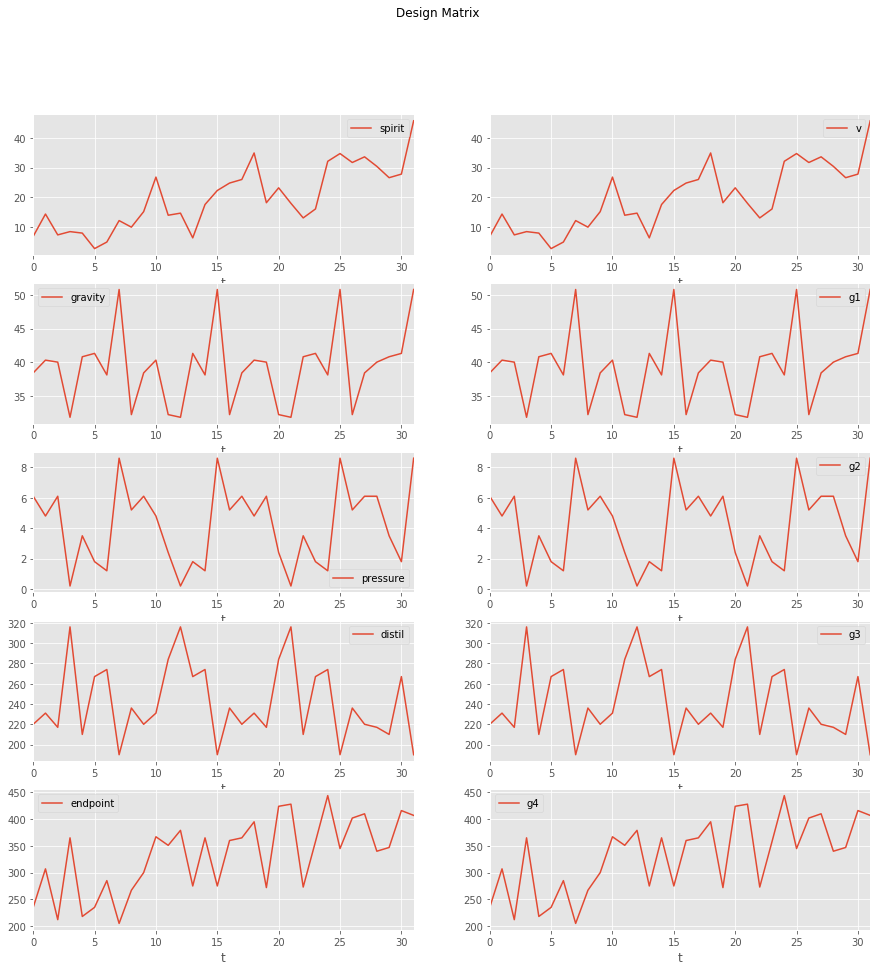

In [23]:
DM.plot()

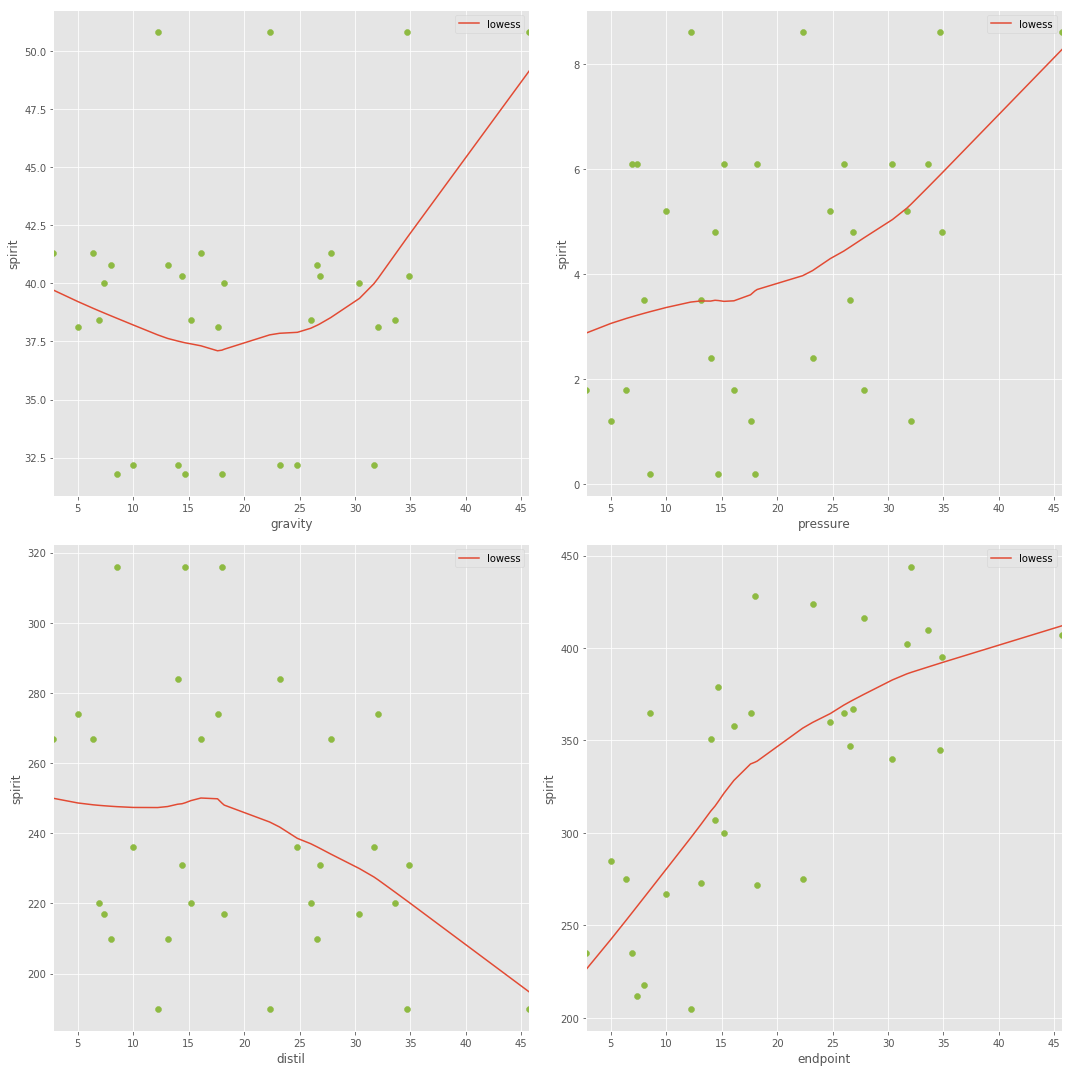

In [24]:
DM.plot_scatter_lowess()

# Grid Search

When fittind models, it is possible to increase the likelihood by adding parameters, but doing so may resut in overfitting. Both AIC, AICc and BIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC

## Information criterions

Likelihood function:
$$
L = p (x | \hat{\theta}, Model)
$$

### Akaike information criterion
$$
AIC = 2k - 2\ln(L)
$$


### Akaike with correction for small sample sizes

$$
AICc = AIC + \dfrac{2k^2 + 2k}{n-k-1}
$$

$ \\ $

*Hirotugu Akaike 1971*

### Bayesian information criterion

$$
BIC = k \ln(n) - 2\ln(L)
$$


where 
* $L$ - is maximum of the likelihood function
* $k$ - number of parameters estimated
* $n$ - number of data points

In [25]:
from itertools import product

from functools import partial
powerset = partial(stb.utils.common.powerset, skip_empty_set=True)

nms = [DM._inv_names.get(k) for k in DM.endog_names]
grid = product(['const'], powerset(nms))
results = []
for elem in grid:
    try:
        c, v = elem
        nm = [c] + list(v)
        gc = stb.GeneralCalibrator(sm.OLS, dict())
        nDM = deepcopy(DM)
        nDM.gX = nDM.gX[nm]
        gm = stb.GeneralModel(gc, nDM)
        gm.fit(range(DM.dm.shape[0]))
        results.append([elem, gm.fitted.aic, nm])
    except Exception as e:
        print(e.args[0])
        continue
pd.DataFrame(results, columns=['elem', 'metric', 'config']).sort_values(
    by=['metric'], ascending=True)[['config', 'metric']]

,config,metric
14,"[const, g1, g2, g3, g4]",146.830808
12,"[const, g1, g3, g4]",147.384177
9,"[const, g3, g4]",150.368974
13,"[const, g2, g3, g4]",150.437747
11,"[const, g1, g2, g4]",166.517725
8,"[const, g2, g4]",175.129118
6,"[const, g1, g4]",202.202708
3,"[const, g4]",223.041157
1,"[const, g2]",240.518642
2,"[const, g3]",242.281116


In [26]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6)
splits = [(train_idx, test_idx) for train_idx, test_idx in tscv.split(DM.dm.index)]

In [27]:
from sklearn.model_selection import train_test_split
splits = [train_test_split(DM.dm.index, shuffle=False) for i in range(6)]

In [28]:
metric = stb.metrics.mean_absolute_percentage_error

CV_error: 0.0779 +/- 0.0000


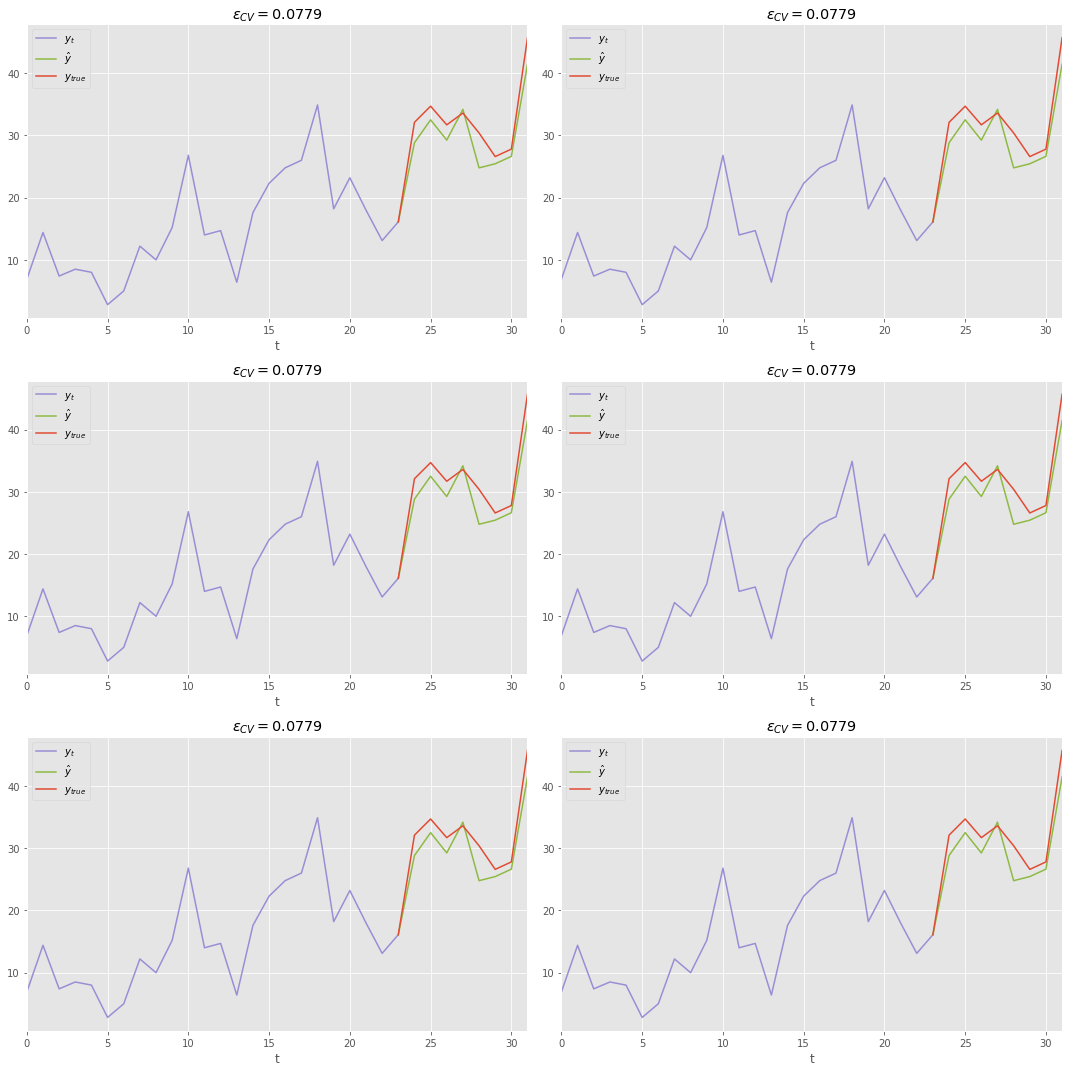

In [29]:
gc = stb.GeneralCalibrator(sm.OLS, dict())
nDM = deepcopy(DM)
nm = DM.gX.columns
nDM.gX = nDM.gX[nm]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run()

# Final Model

In [30]:
gc = stb.GeneralCalibrator(sm.OLS, dict())
nDM = deepcopy(DM)
nm = DM.gX.columns
nDM.gX = nDM.gX[nm]
gm = stb.GeneralModel(gc, nDM)

gm.fit(range(DM.n))

gm.forecast(range(DM.n))

print(gm.fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      v   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     171.7
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           8.82e-19
Time:                        06:48:13   Log-Likelihood:                -68.415
No. Observations:                  32   AIC:                             146.8
Df Residuals:                      27   BIC:                             154.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.8208     10.123     -0.674      0.5

# Diagnostics

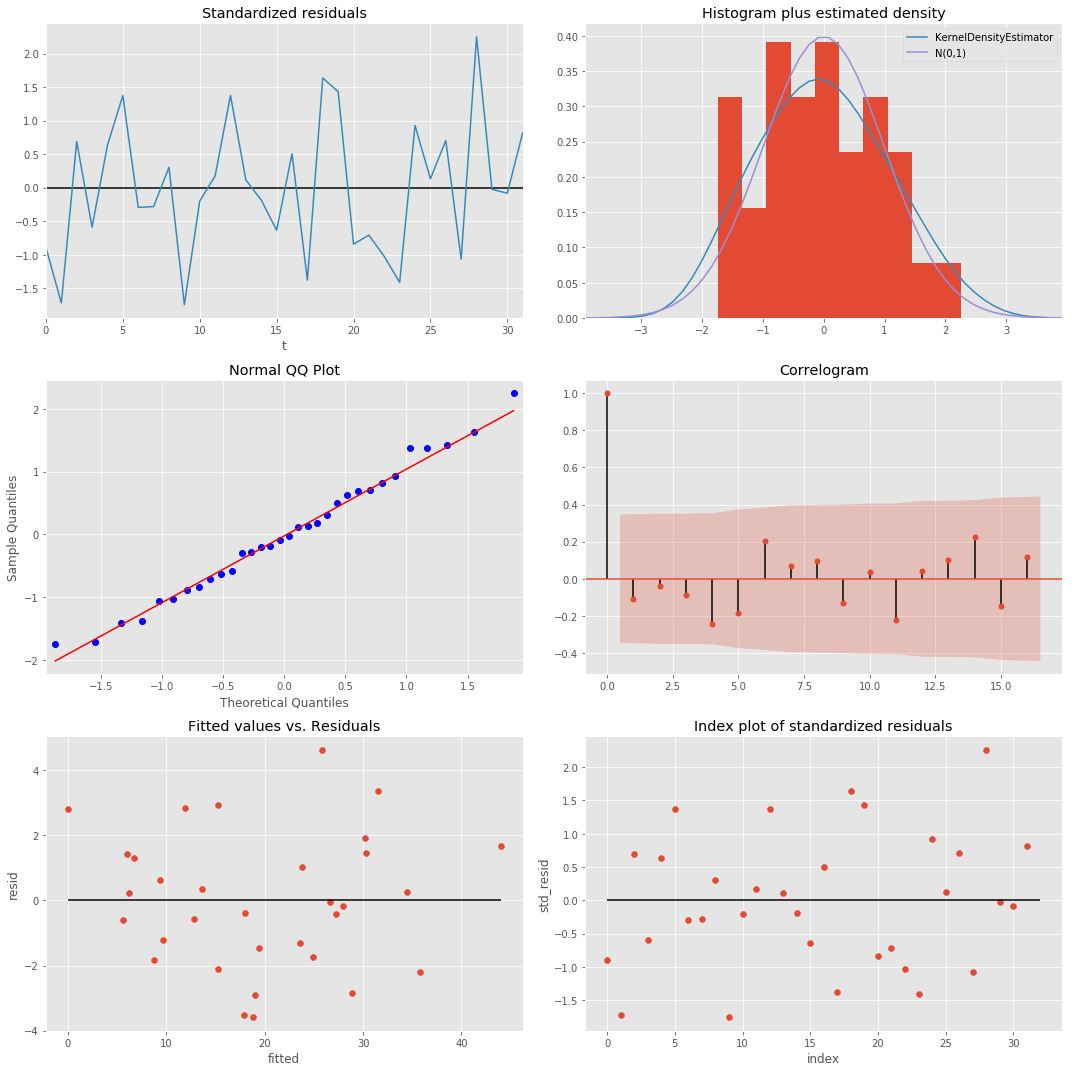

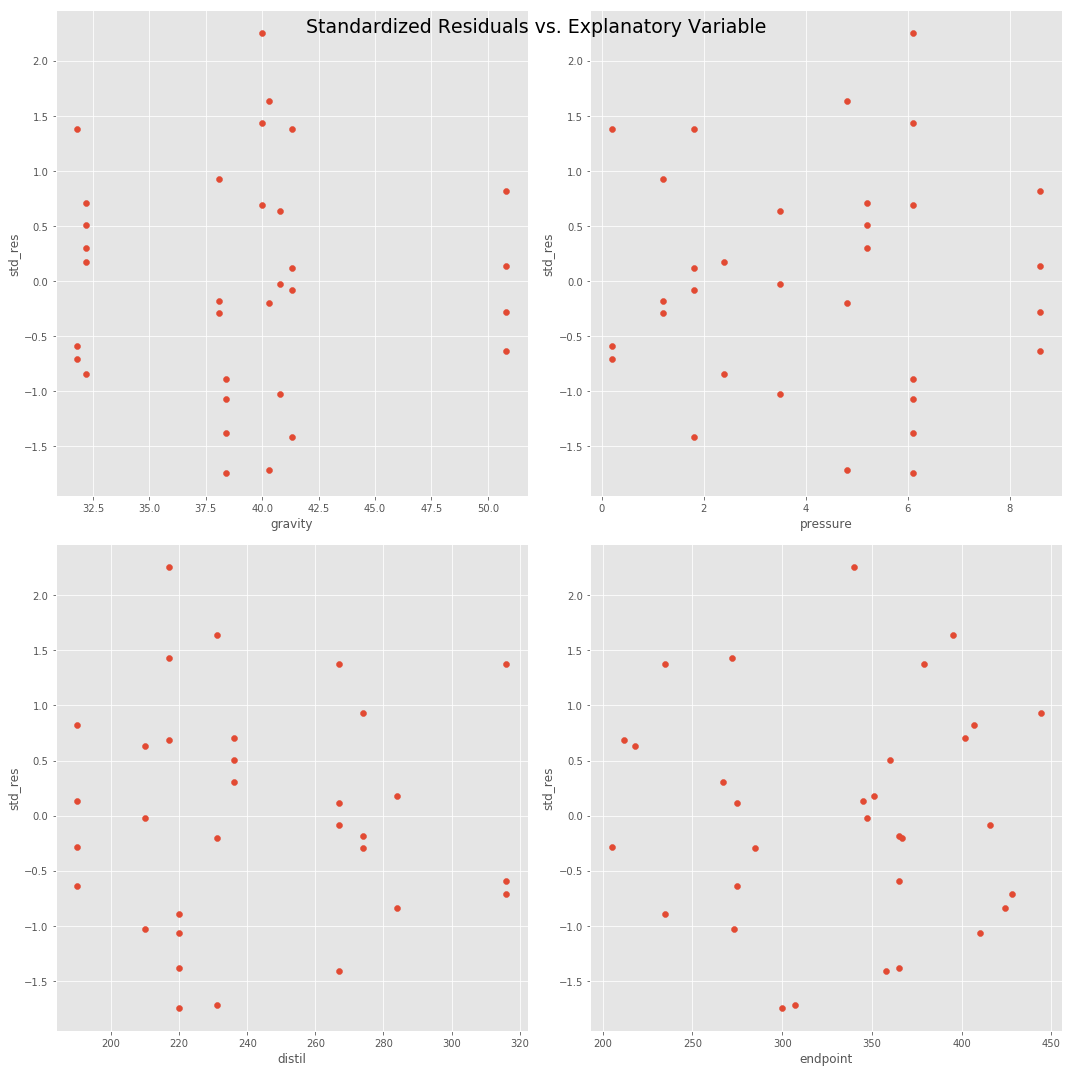

In [31]:
gm.plot_diagnostics()

**Jarque Bera test for 3d and 4th moment matching to the Normal one:**

In [32]:
stb.stat_tests.test_jarque_bera(gm.std_residuals)

H0: sample datasets have the skewness and kurtosis matching a normal distribution

Results of Jarque Bera Test:
Test Statistic    0.719479
p-value           0.697858
skew              0.189701
kurtosis          2.370983
dtype: float64

Can NOT reject H0


**Breusch Pagan Test for homoscedasticity**

In [33]:
stb.stat_tests.test_breusch_pagan(gm.residuals, gm.fitted.model.exog)

H0: series is homoskedastic

Results of BP Test:
Lagrange multiplier statistic    1.006196
p-value                          0.908855
f-value                          0.219135
f p-value                        0.925434
dtype: float64

Can NOT reject H0


**Influence DataFrame**

In [34]:
infl = gm.fitted.get_influence()

df_infl = infl.summary_frame()

df_infl[:5]

,dfb_const,dfb_g1,dfb_g2,dfb_g3,dfb_g4,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
t,,,,,,,,,,,
0,-0.052515,0.136946,-0.124729,-0.055942,0.241276,0.023921,-0.879186,0.134002,-0.345842,-0.875372,-0.344342
1,-0.043683,0.008067,-0.003350,0.017628,0.080910,0.019408,-1.609131,0.036123,-0.311510,-1.660687,-0.321490
2,0.031388,-0.067764,0.084810,0.050215,-0.227035,0.016605,0.687432,0.149440,0.288145,0.680564,0.285266
3,0.119669,-0.012083,-0.088256,-0.170371,0.060443,0.015882,-0.598715,0.181359,-0.281802,-0.591463,-0.278388
4,0.329409,-0.085229,-0.317096,-0.304572,-0.142062,0.037234,0.686964,0.282893,0.431472,0.680092,0.427156


**Leverage vs Studentized Residuals and Cook's distance**

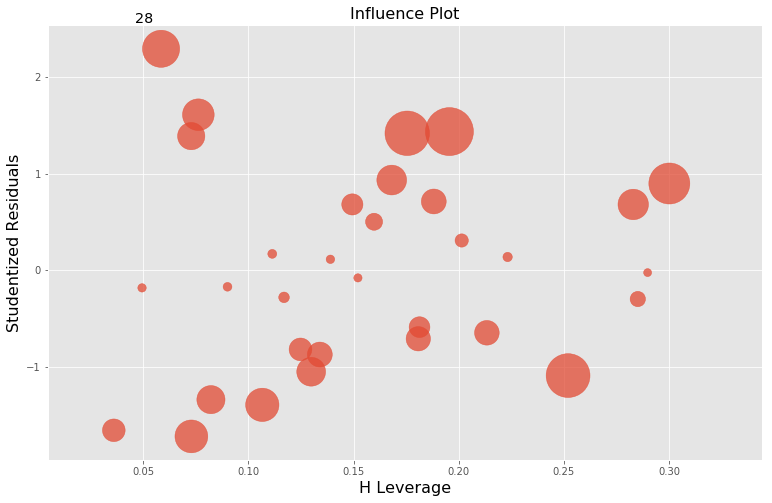

In [35]:
with mpl.rc_context():
    mpl.rc("figure", figsize=figsize)
    sm.graphics.influence_plot(gm.fitted)
    plt.show()